In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.core.pylabtools as pylabtools # for figsize
import seaborn as sns



def mask_data(data,*args):
    mask_and=np.array(args).all(0)
    return data[mask_and]

/Users/borundev/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Time series analysis: No external data

In [3]:
data=pd.read_csv("processed_data.csv")
data['date']=pd.to_datetime(data.date)

/Users/borundev/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (16,17,19,24,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.shape

(295825, 47)

In [5]:
data=data[data.TYPEINTERVENTIONCODE=='P']
data.shape

(228249, 47)

In [6]:
# since we want to make a time series in hours we need to make each "observation" or row correspond to a unique "hour"

data['delta_date']=(data.date-data.date[0])
data['delta_date']=map(lambda x : x.days,data.delta_date)

data['delta_time']=data.delta_date*24+data.time
data['delta_time']=map(lambda x: int(x),data.delta_time)

# since the original time includes minutes and we do not care about it we floor it
data['time_bin']=map(lambda x: int(x),data.time)

In [7]:
# fill in FIPMINTOTAL with mean for missing values
data.loc[data.FIPMINTOTAL.isnull(),'FIPMINTOTAL']=data.FIPMINTOTAL.mean()

## Dont run anything below this till the place a similar comment tells you to run

In [8]:
# For a time series analysis we cannot use other variables not related to date (we could include time and make the 
# intervals in hours instead of day but ultimatel the only fundamental information). Of course we can later add variables
# like the weather that are functions of the date

# If we want to analyze locations  (u'SECT_GEO_PEC', u'SECT_GEO_2_PEC') for instance we will have to do individual time series
# If we suspect cross correlations (and I don't) we could then look for those.


# create a new data frame that has the total calls for given unique hour given by 'delta_time' i.e. number of hours
# since the beginnning of the data set

columns_to_use=['date','month','day','time_bin','delta_date','delta_time'] 
nd=pd.DataFrame({'total' : data.groupby( columns_to_use).size()}).reset_index()


In [9]:
# since everything is identified by 'delta_time' we make it the index
nd=nd.set_index('delta_time')

# and since some data must be missing we need to reindex
# when we include ambulance engagement we will need an extra date so +2 instead of +1
nd=nd.reindex(range(nd.index.max()+2))

# and check if something is missing
nd.head()

,date,month,day,time_bin,delta_date,total
delta_time,,,,,,
0,2004-01-01,1,3,0,0,6
1,2004-01-01,1,3,1,0,6
2,2004-01-01,1,3,2,0,2
3,2004-01-01,1,3,3,0,3
4,2004-01-01,1,3,4,0,2


In [11]:
# we now fill in the empty rows date, month, day and time_bin all uniquely identified by the index which is delta_time

start_date=nd.iloc[0].date

for index in nd[pd.isnull(nd.date)].index:
    nd.loc[index,'date']=start_date+pd.Timedelta(days=index/24)
    nd.loc[index,'month']=nd.loc[index,'date'].month
    nd.loc[index,'day']=pd.datetime.weekday(nd.loc[index,'date'])
    nd.loc[index,'time_bin']=np.mod(index,24)

nd['delta_date']=nd.index/24

In [12]:
# Now we impute the missing values for total. This is NOT the best way to do it. We could take averages
# based on week and time of day for instance

nd.loc[nd.total.isnull(),'total']=int(nd.total.mean()) # should have a better way to impute

# make sure the last row total is zero as it was added fictitiously (see above)
nd.loc[87672,'total']=0

In [13]:
# check that the missing values are filled
nd.tail(10)

,date,month,day,time_bin,delta_date,total
delta_time,,,,,,
87663,2013-12-31,12,1,15,3652,2
87664,2013-12-31,12,1,16,3652,1
87665,2013-12-31,12,1,17,3652,3
87666,2013-12-31,12,1,18,3652,5
87667,2013-12-31,12,1,19,3652,4
87668,2013-12-31,12,1,20,3652,1
87669,2013-12-31,12,1,21,3652,3
87670,2013-12-31,12,1,22,3652,3
87671,2013-12-31,12,1,23,3652,3


In [15]:
# we drop delta_time and delta_date as we do not need them anymore. In principle we do not need 'date' anymore either
# but we keep it just to make sure nothing has gotten scrambled at some later point
nd=nd.reset_index()
#nd_cleaned=nd.drop(['delta_date'],axis=1)

In [ ]:
#nd_cleaned.head()

In [16]:
nd.month=nd.month.astype(int)
nd.day=nd.day.astype(int)
nd.time_bin=nd.time_bin.astype(int)

In [ ]:
# at this processed data so as not to have to do it again
nd.to_csv("classification_by_hour_data_priority.csv",index=False)

In [ ]:
# if nothing is changed above we start from here
nd=pd.read_csv("classification_by_hour_data_priority.csv")

In [17]:
data[['time_bin','FIPMINTOTAL']].head()

,time_bin,FIPMINTOTAL
0,10,43.00000
1,18,56.00000
2,0,61.14459
3,1,61.14459
4,5,61.14459


In [18]:
data['end_time_bin']=data['delta_time']+data.FIPMINTOTAL/60
data['end_time_bin']=data['end_time_bin'].astype(int)

In [19]:
data[['time_bin','FIPMINTOTAL','end_time_bin']].head()

,time_bin,FIPMINTOTAL,end_time_bin
0,10,43.00000,10
1,18,56.00000,18
2,0,61.14459,1
3,1,61.14459,2
4,5,61.14459,6


In [20]:
data.end_time_bin.describe()

count    228249.000000
mean      46493.068947
std       25243.000890
min           0.000000
25%       24875.000000
50%       47871.000000
75%       68728.000000
max       87672.000000
Name: end_time_bin, dtype: float64

In [21]:
nd.delta_time.describe()

count    87673.000000
mean     43836.000000
std      25309.159412
min          0.000000
25%      21918.000000
50%      43836.000000
75%      65754.000000
max      87672.000000
Name: delta_time, dtype: float64

In [22]:
nd['number_ambulances_engaged']=0
nd['total_calls']=0
print data.shape[0]

for i in range(data.shape[0]):
    if i % 1000==0:
        print i
    s=data.iloc[i].delta_time
    e=data.iloc[i].end_time_bin
    nd.loc[s,'total_calls']=nd.loc[s,'total_calls']+1
    for k in range(s,e+1):
        nd.loc[k,'number_ambulances_engaged']=nd.loc[k,'number_ambulances_engaged']+1

228249
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000


In [ ]:
#1.0*np.sum(nd.number_ambulances_engaged<nd.total)/nd.shape[0] # how can this happen?

In [ ]:
#nd.number_ambulances_engaged.describe()

In [ ]:
#for i in range(87673):
#    if i%1000==0:
#        print i
#    nd.loc[i,'total_calls']=np.sum(data.delta_time==i)

In [23]:
1.0*np.sum(nd.number_ambulances_engaged<nd.total_calls)/nd.shape[0] # how can this happen?

0.0

In [31]:
# at this processed data so as not to have to do it again
nd.drop('index',axis=1,inplace=True)
nd.to_csv("classification_by_hour_data_priority_3.csv",index=False)

## Start running from here

In [145]:
nd=pd.read_csv("classification_by_hour_data_priority_3.csv")
nd.head()

,delta_time,date,month,day,time_bin,delta_date,total,number_ambulances_engaged,total_calls
0,0,2004-01-01,1,3,0,0,6,6,6
1,1,2004-01-01,1,3,1,0,6,9,6
2,2,2004-01-01,1,3,2,0,2,3,2
3,3,2004-01-01,1,3,3,0,3,3,3
4,4,2004-01-01,1,3,4,0,2,2,2


In [146]:
# these two lines do nothign but since the variables beneath use these names and I didnt want to go back and change
# stuff I keep them

nd['total']=nd.number_ambulances_engaged # if we want total_calls change this to total calls
nd_cleaned=nd

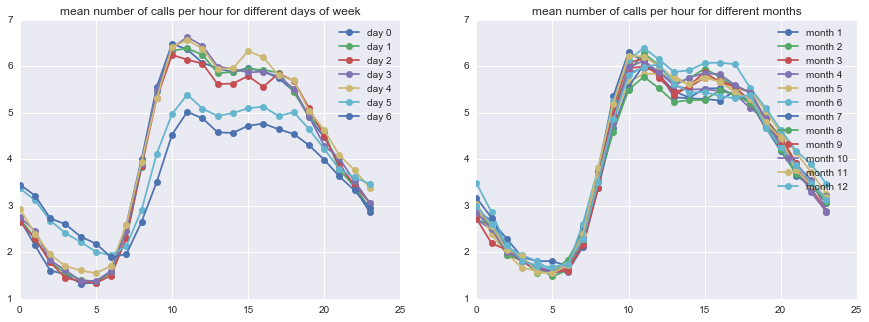

In [147]:
# we plot the behavior of mean number of calls by the hour for weekdays and months

pylabtools.figsize(15,5)
plt.subplot(121)
nd_mean=nd_cleaned.groupby(['day','time_bin']).mean().reset_index().drop('month',axis=1)
for i in range(7):
    data_masked=mask_data(nd_mean,nd_mean.day==i)
    plt.plot(data_masked.time_bin,data_masked.total,"-o",label="day "+str(i))
plt.title("mean number of calls per hour for different days of week")
plt.legend()

plt.subplot(122)
nd_mean=nd_cleaned.groupby(['month','time_bin']).mean().reset_index().drop('day',axis=1)
for i in range(1,13):
    data_masked=mask_data(nd_mean,nd_mean.month==i)
    plt.plot(data_masked.time_bin,data_masked.total,"-o",label="month "+str(i))
plt.title("mean number of calls per hour for different months")
plt.legend()

In [176]:
# we calculate a dataframe with this information
nd_mean=nd_cleaned.groupby(['month','day','time_bin']).mean().reset_index().drop(['delta_time','delta_date','number_ambulances_engaged','total_calls'],axis=1)

nd_mean.columns=['month','day','time_bin','mu']
nd_mean.head()

,month,day,time_bin,mu
0,1,0,0,2.555556
1,1,0,1,2.222222
2,1,0,2,1.977778
3,1,0,3,1.533333
4,1,0,4,1.600000


In [177]:
# merge the two data frame
nd_merged=nd_cleaned.merge(nd_mean,left_on=['month','day','time_bin'],right_on=['month','day','time_bin'])

In [178]:
# and see how it looks
nd_merged.sort_values(by='delta_time',inplace=True)
nd_merged.index=nd_merged.delta_time.values
nd_merged[['delta_time','time_bin','total','mu']].head()

,delta_time,time_bin,total,mu
0,0,0,6,2.727273
1,1,1,9,2.590909
2,2,2,3,1.977273
3,3,3,3,1.681818
4,4,4,2,1.522727


In [151]:
cond1=np.array([nd_merged.total.values>13,nd_merged.time_bin.values>=7,nd_merged.time_bin.values<19]).all(0)
cond2=np.array([nd_merged.total.values>9,nd_merged.time_bin.values<7]).all(0)
cond3=np.array([nd_merged.total.values>9,nd_merged.time_bin.values>=19]).all(0)
combined_condition=np.array([cond1,cond2,cond3]).any(0)

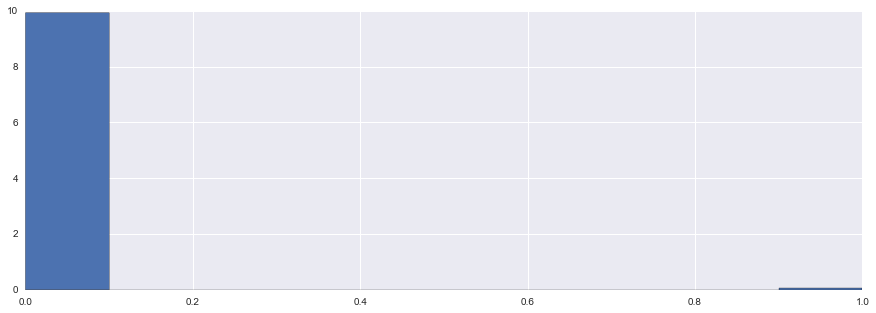

In [179]:

# another approach would be to ask if there is some persistance in the hours that see above average and those that see belo
# this would be some ising model like clumpign of spins
# we will try this


nd_merged['busy']=(combined_condition).astype(int)

# this gives about 15% of the days busy. if this doesn't 'feel' right we can reduce the threshold to increase
# the number of days classified as busy
nd_merged['busy'].hist(normed='True')

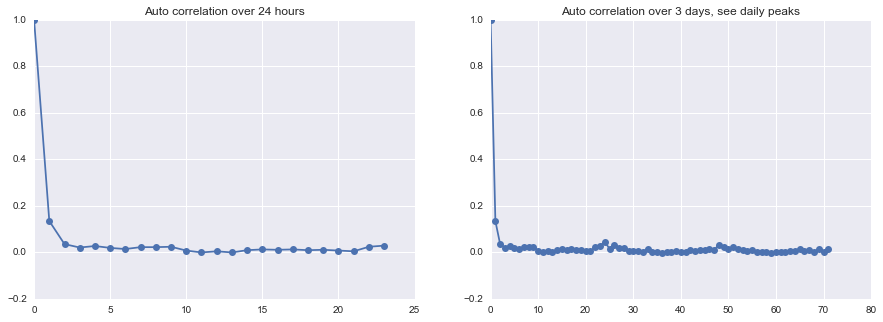

In [180]:
# Now we can test Niquille's intuition. He seems to claim busy hours come in chunks. That should mean that there
# should be correlations over the first few hours. However we fail to see this.


pylabtools.figsize(15,5)
plt.subplot(121)
autocorrelations=pd.Series([nd_merged.busy.autocorr(lag=l) for l in range(24)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")
plt.title("Auto correlation over 24 hours")

plt.subplot(122)
autocorrelations=pd.Series([nd_merged.busy.autocorr(lag=l) for l in range(3*24)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")

plt.title("Auto correlation over 3 days, see daily peaks")

In [181]:
a=nd_final.busy[1:]
b=nd_final.busy[:-1]

from scipy.stats import spearmanr

spearmanr(a,b)

SpearmanrResult(correlation=0.13443770239330194, pvalue=0.0)

In [182]:
total_lag_hours=3
for i in range(1,total_lag_hours+1):
    nd_merged['lag'+str(i)]=nd_merged.busy.shift(i)

cols=['lag'+str(i) for i in range(1,total_lag_hours+1) ]

In [183]:
# We cant use the first 'total_lag_days' as they do not have complete information accroding to the above model
nd_final=nd_merged[total_lag_hours:]

In [184]:
nd_final.head()

,delta_time,date,month,day,time_bin,delta_date,total,number_ambulances_engaged,total_calls,mu,busy,lag1,lag2,lag3
3,3,2004-01-01,1,3,3,0,3,3,3,1.681818,0,0,0,0
4,4,2004-01-01,1,3,4,0,2,2,2,1.522727,0,0,0,0
5,5,2004-01-01,1,3,5,0,3,3,3,1.522727,0,0,0,0
6,6,2004-01-01,1,3,6,0,2,2,1,1.318182,0,0,0,0
7,7,2004-01-01,1,3,7,0,5,5,4,2.409091,0,0,0,0


In [185]:
y=nd_final.busy.values

In [187]:
numerical_cols=[]
catecorical_cols=cols+['day','month','time_bin']
X_numerical=nd_final[numerical_cols].values
X_categorical=nd_final[catecorical_cols].values

In [188]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc.fit(X_categorical)
X_categorical=enc.transform(X_categorical).toarray()

In [189]:
X=np.hstack((X_numerical,X_categorical))

In [190]:
from sklearn.cross_validation import train_test_split

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [192]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [193]:
clf=ExtraTreesClassifier(n_estimators=200,n_jobs=-1)
clf=LogisticRegression()
#clf=SVC()
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [194]:
y_pred_rt = clf.predict_proba(X_test)[:, 1]

In [195]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

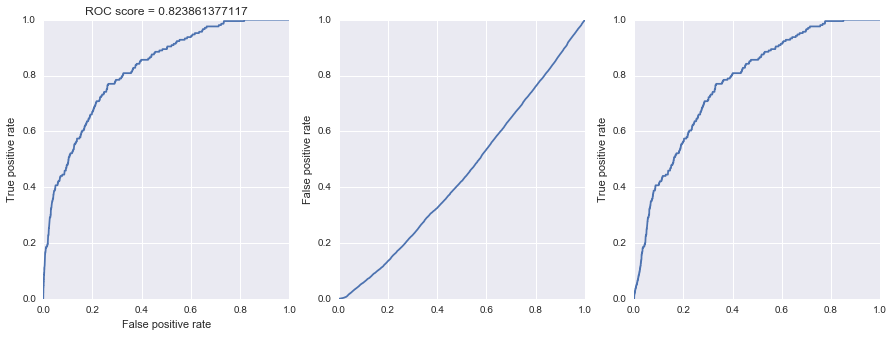

In [196]:
pylabtools.figsize(15,5)

plt.subplot(131)
plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC score = "+str(roc_auc_score(y_test, y_pred_rt)))
plt.subplot(132)
plt.plot(np.linspace(0,1,fpr_rt_lm.shape[0]),fpr_rt_lm)
plt.ylabel('False positive rate')
plt.subplot(133)
plt.plot(np.linspace(0,1,fpr_rt_lm.shape[0]),tpr_rt_lm)
plt.ylabel('True positive rate')

(array([  11.,   11.,    5.,    2.,    3.,    0.,    0.,    0.,    1.,
          13.,   47.,   43.,   46.,   32.,   23.,   28.,   28.,   22.,
          10.,  149.,   81.,   39.,   13.,   12.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

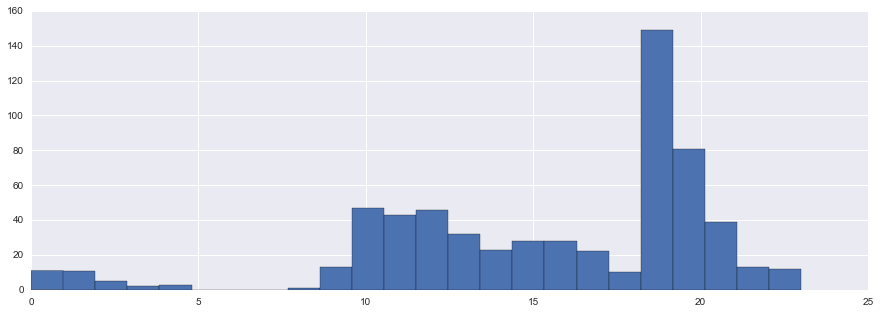

In [197]:
plt.hist(nd_final[nd_final.busy==1].time_bin,bins=24)

(28931, 43)